##9.49 Final Project
Emergence of Grid Cells in Biological RNNs
Ashley Benallo and Jack King

In [2]:
from shapely.geometry import Polygon, Point
import random
import torch
import math
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn import MSELoss
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
torch.manual_seed(1)

In [8]:
# Config
data_config = {
          "time_steps": 500,
          "step_size": 0.1,
          "diffusion_coefficient": 0.1,
          "noise_variance": 0.1,
          "dataset_len": 100000,
          "batch_size": 500}

hidden_dim = 100
input_dim = 2

config = {"input_dim": input_dim,
          "hidden_dim": hidden_dim,
          "output_dim": 2,
          "epochs": 20,
          "tau_multiplier": 1/10,
          "time_steps": 500,
          "rec_init": (0.0, 1.5**2 / hidden_dim),
          "out_init": (0.0, 0.0),
          "in_init": (0.0, 1/input_dim),
          "batch_size": 500}

In [ ]:
#V2 with speed and direction
# def generate_walk_2d(path_length, vertices, starting_pos, max_speed=3, max_direction=np.pi/2, round_vals=False):
#   #max speed + direction should be adjusted by polygon area
#   polygon = Polygon(vertices)
#   path = [starting_pos]
#   speed_direction = [[0,0]]

#   for _ in range(path_length - 1):
#     speed = random.uniform(0, max_speed)
#     direction = (random.uniform(-max_direction, max_direction) + speed_direction[-1][1]) % (2*np.pi)
#     x_speed = speed * math.cos(direction)
#     y_speed = speed * math.sin(direction)

#     x_pos = path[-1][0] + x_speed
#     y_pos = path[-1][1] + y_speed

#     if not polygon.contains(Point(x_pos, y_pos)):
#       closest_point = polygon.exterior.interpolate(polygon.exterior.project(Point(x_pos, y_pos)))
#       x_pos = closest_point.x
#       y_pos = closest_point.y

#       dx = x_pos - path[-1][0]
#       dy = y_pos - path[-1][1]
#       speed = math.sqrt(dx ** 2 + dy ** 2)
#       direction = math.atan2(dy, dx)

#     if round_vals:
#       x_pos = round(x_pos, 2)
#       y_pos = round(y_pos, 2)
#       speed = round(speed,2)
#       direction = round(direction,2)

#     path.append([x_pos, y_pos])
#     speed_direction.append([speed,direction])

#   return path, speed_direction

In [ ]:
#plot example random walk
# starting_pos = [0,0]
# border_vertices = [(0, 0), (5, 0), (5, 5), (0, 5)]
# verticies_tri = [(0,10),(-10,-10),(10,-10)] # equilateral triagle
# path, speed_direction = generate_walk_2d(500,border_vertices,starting_pos,max_direction=np.pi/2, max_speed=1.75)
# # Extract x and y coordinates
# x_coords = [pair[0] for pair in path]
# y_coords = [pair[1] for pair in path]

# # Plotting x-y pairs
# plt.figure(figsize=(8, 6))
# plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='b')
# plt.title('Position Over Time')
# plt.xlabel('X-coordinate')
# plt.ylabel('Y-coordinate')
# plt.grid(True)
# plt.tight_layout()

# # Display the plot
# plt.show()


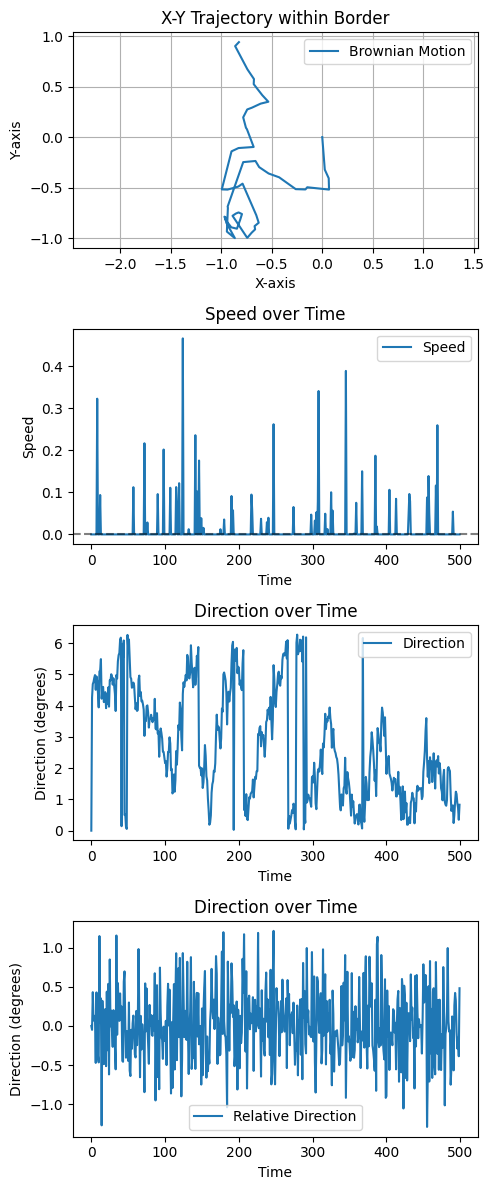

In [5]:
# Function to check if a point is inside the polygon
def is_inside_polygon(point, polygon):
  return polygon.contains(point)

# Function to resample direction based on Brownian motion
def resample_speed(current_speed,step_size):
  return abs(current_speed + np.random.normal(scale=np.sqrt(step_size/5)))

def brownian_walk_2d(num_steps, step_size, diffusion_coefficient, border_vertices, zero_prob = 0.9):
  border_polygon = Polygon(border_vertices)

  # Initialize arrays to store particle positions, speeds, and directions
  x = np.zeros(num_steps)
  y = np.zeros(num_steps)
  speeds = np.zeros(num_steps)
  directions = np.zeros(num_steps)
  delta_directions = np.zeros(num_steps)
  # Initial direction and position
  direction = np.random.uniform(0, 2 * np.pi)
  speed = 0
  #x[0], y[0] = np.random.uniform(0, 5), np.random.uniform(0, 5)
  # Simulate Brownian motion
  for i in range(1, num_steps):
      # Resample direction based on Brownian motion
      theta = np.random.normal(scale=np.sqrt(2* step_size))
      direction = (direction + theta) % (2*np.pi)
      speed = resample_speed(speed, step_size)
      # Calculate dx and dy components from the direction
      dx = speed * np.cos(direction)
      dy = speed * np.sin(direction)

      if np.random.rand() < zero_prob:  # 90% probability for speed to be 0
        dx, dy, speed = 0, 0, 0

      # Update particle position
      new_x = x[i - 1] + dx
      new_y = y[i - 1] + dy

      # Check if the new position is inside the border, adjust if necessary
      new_point = Point(new_x, new_y)

      while not is_inside_polygon(new_point, border_polygon):
          # If the new position is outside the border, resample the direction
          theta = np.random.normal(scale=np.sqrt(2 * step_size))
          direction = (direction + theta) % (2*np.pi)
          speed = resample_speed(speed, step_size)
          # Calculate dx and dy components from the direction
          dx = speed * np.cos(direction)
          dy = speed * np.sin(direction)
          # Update particle position
          new_x = x[i - 1] + dx
          new_y = y[i - 1] + dy

          # Check if the new position is inside the border, adjust if necessary
          new_point = Point(new_x, new_y)

      x[i] = x[i - 1] + dx
      y[i] = y[i - 1] + dy

      # Calculate speed and store direction
      speed = np.sqrt(dx**2 + dy**2)
      speeds[i] = speed
      directions[i] = direction
      delta_directions[i] = theta

  return x,y,speeds,directions, delta_directions


# Parameters
num_steps = 500  # Number of steps
step_size = 0.1   # Step size
diffusion_coefficient = 0.1  # Diffusion coefficient

# Define the border polygon (you can change the vertices to define your border)
border_vertices = [(-1, -1), (1, -1), (1, 1), (-1, 1)]

x, y, speeds, directions, delta_directions = brownian_walk_2d(num_steps,step_size,diffusion_coefficient,border_vertices)

# Plot x-y trajectory, speed, and direction in separate plots
plt.figure(figsize=(5, 12))

# X-Y Trajectory
plt.subplot(4, 1, 1)
plt.plot(x, y, label='Brownian Motion')
plt.title('X-Y Trajectory within Border')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.axis('equal')
plt.legend()

# Speed
plt.subplot(4, 1, 2)
plt.plot(speeds, label='Speed')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Speed over Time')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.legend()

# Direction
plt.subplot(4, 1, 3)
plt.plot(directions, label='Direction')
plt.title('Direction over Time')
plt.xlabel('Time')
plt.ylabel('Direction (degrees)')
plt.legend()

# Relative irection
plt.subplot(4, 1, 4)
plt.plot(delta_directions, label='Relative Direction')
plt.title('Direction over Time')
plt.xlabel('Time')
plt.ylabel('Direction (degrees)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
class PathDataset(torch.utils.data.Dataset):
    def __init__(self, velocity_sets, path_sets, noise_sets):
        self.velocity_sets = velocity_sets
        self.path_sets = path_sets
        self.noise_sets = noise_sets

    def __len__(self):
        return len(self.velocity_sets)

    def __getitem__(self, idx):
      return {
          "inputs": self.velocity_sets[idx].float(),
          "labels": self.path_sets[idx].float(),
          "noise": self.noise_sets[idx].float() }

In [7]:
#Step 2: Format data into input, output labels for training and split into train/test set

# Parameters
num_steps = data_config["time_steps"]  # Number of steps
step_size = data_config["step_size"]  # Step size
diffusion_coefficient = data_config["diffusion_coefficient"] # Diffusion coefficient
dataset_len = data_config["dataset_len"]

# Define the border polygon (you can change the vertices to define your border)
border_vertices = [(-1, -1), (1, -1), (1, 1), (-1, 1)]

#initialize
velocity_sets = tensor.zeros((dataset_len,
path_sets = []
noise_sets = []

for i in range(config["dataset_len"]):
  x, y, speeds, directions, delta_directions = brownian_walk_2d(num_steps,step_size,diffusion_coefficient,border_vertices)
  noise = torch.normal(0.0, data_config["noise_variance"], size=(data_config["time_steps"], config["hidden_dim"]))

  path = torch.as_tensor([x, y]).reshape(-1, 2)
  velocities = torch.as_tensor([speeds, directions]).reshape(-1, 2)
  velocity_sets.append(velocities)
  path_sets.append(path)
  noise_sets.append(noise)

dataset = PathDataset(velocity_sets, path_sets, noise_sets)
torch.save(dataset, "dataset_100000.pt")

dataloader = DataLoader(dataset, batch_size=config["batch_size"])

<ipython-input-7-332455a52e3f>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  path = torch.as_tensor([x, y]).reshape(-1, 2)


KeyboardInterrupt: ignored

Update rule ($h$ is hidden state with dimension $N$, $I$ is input with dimension $N_{in}$)
$$h_{i}(t+1) = h_i (t) + \frac{1}{\tau} \frac{\tau}{m_{\tau}} (-h_i (t) + \sum^N_{j=1} W_{ij}^{rec} tanh(h_i (t)) + \sum^{N_{in}}_{k=1} W_{ik}^{in} I_k(t) + b_i + noise_i(t))$$
Output:
$$y_j(t) = \sum_{i=1}^{N} W_{ij}^{out} tanh(h_i (t))$$

So in matrix form we have:

$$h(t+1) = h(t) + \frac{1}{\tau} \frac{\tau}{m_{\tau}} (-h(t) + W^{rec} tanh(h) + W^{in} I + b + noise(t))$$

And the firing rate of each neuron is:

$$tanh(h_i)$$

In [ ]:
#Step 3: Intialize RNN with biological features
class RNN(nn.Module):
  def __init__(self, config):
    super(RNN, self).__init__()
    input_dim = config["input_dim"]
    hidden_dim = config["hidden_dim"]
    output_dim = config["output_dim"]
    self.tau_multiplier = config["tau_multiplier"]

    self.W_in = nn.Linear(input_dim, hidden_dim, bias=False)
    self.W_rec = nn.Linear(hidden_dim, hidden_dim, bias=False)
    self.W_out = nn.Linear(hidden_dim, output_dim, bias=False)
    self.b = nn.Parameter(torch.zeros((1, hidden_dim)))

  def __call__(self, input, h_prev, noise):
    h_tanh = torch.tanh(h_prev)
    inp = self.W_in(input)
    rec = self.W_rec(h_tanh)
    h_current = h_prev + self.tau_multiplier * (-h_prev + inp + rec + self.b + noise)
    activations = torch.tanh(h_current)
    y = self.W_out(activations)
    return y, h_current, self.W_in.weight, self.W_out.weight, activations

  def initialize_weights(self):
    for name, param in self.named_parameters():
      if 'W_rec' in name:
        if 'weight' in name:
          nn.init.normal_(param, mean=config["rec_init"][0], std = config["rec_init"][1])
        if 'bias' in name:
          nn.init.zeros_(param)
      elif 'W_in' in name:
        if 'weight' in name:
          nn.init.normal_(param, mean=config["in_init"][0], std = config["in_init"][1])
        if 'bias' in name:
          nn.init.zeros_(param)
      elif 'W_out' in name:
        if 'weight' in name:
          nn.init.normal_(param, mean=config["out_init"][0], std = config["out_init"][1])
        if 'bias' in name:
          nn.init.zeros_(param)

In [ ]:
model = RNN(config)
model.initialize_weights()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

RNN(
  (W_in): Linear(in_features=2, out_features=100, bias=False)
  (W_rec): Linear(in_features=100, out_features=100, bias=False)
  (W_out): Linear(in_features=100, out_features=2, bias=False)
)

In [ ]:
def scaled_frobenius_norm(matrix):
    squared_elements = matrix ** 2
    sum_of_squares = torch.sum(squared_elements)
    num_elements = matrix.numel()
    return sum_of_squares / num_elements

In [ ]:
#Step 4: Train RNN
optimizer = Adam(model.parameters(), lr=0.01)
loss_fn = MSELoss()

every_step_loss = False

for epoch in range(config["epochs"]):
  epoch_loss = 0
  for i, batch in enumerate(tqdm(dataloader)):

    length = batch["inputs"].shape[1]
    batch_size = batch["inputs"].shape[0]

    inputs = batch["inputs"].reshape(length, batch_size, -1).to(device)
    labels = batch["labels"].reshape(length, batch_size, -1).to(device)
    noises = batch["noise"].reshape(length, batch_size, -1).to(device)

    hidden_state = torch.zeros((1, config["hidden_dim"])).to(device)

    if every_step_loss:
      for input, label, noise in zip(inputs, labels, noises):
        optimizer.zero_grad()

        output, hidden_state, W_in, W_out, activations = model(input, hidden_state, noise)
        l2_reg = scaled_frobenius_norm(W_in) + scaled_frobenius_norm(W_out)
        metabolic_reg = scaled_frobenius_norm(activations)
        loss = loss_fn(output, label) + l2_reg + metabolic_reg
        epoch_loss += loss.item()
        hidden_state = hidden_state.detach()
        loss.backward()
        optimizer.step()

    else:
      total_loss = 0
      for input, label, noise in zip(inputs, labels, noises):
        optimizer.zero_grad()

        output, hidden_state, W_in, W_out, activations = model(input, hidden_state, noise)
        l2_reg = scaled_frobenius_norm(W_in) + scaled_frobenius_norm(W_out)
        metabolic_reg = scaled_frobenius_norm(activations)
        loss = loss_fn(output, label) + l2_reg + metabolic_reg
        total_loss += loss
        epoch_loss += loss.item()

      total_loss.backward()
      optimizer.step()

  print("Epoch: {} Loss: {}".format(epoch+1, epoch_loss / (config["dataset_len"] * config["time_steps"])))


100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Epoch: 1 Loss: 0.03666911792755127


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Epoch: 2 Loss: 0.03276511392250061


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Epoch: 3 Loss: 0.03240866057338715


100%|██████████| 20/20 [00:16<00:00,  1.25it/s]


Epoch: 4 Loss: 0.03219629340248108


100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


Epoch: 5 Loss: 0.032031014179039


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Epoch: 6 Loss: 0.03189636320419312


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Epoch: 7 Loss: 0.03177915427055359


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Epoch: 8 Loss: 0.0316930513217926


100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Epoch: 9 Loss: 0.031622367561340334


100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


Epoch: 10 Loss: 0.03156381628074646


100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


Epoch: 11 Loss: 0.03149932308692932


100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


Epoch: 12 Loss: 0.03142681654434204


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Epoch: 13 Loss: 0.03137282860832214


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Epoch: 14 Loss: 0.03132790289592743


100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Epoch: 15 Loss: 0.031284054848098757


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Epoch: 16 Loss: 0.03124226575984955


100%|██████████| 20/20 [00:15<00:00,  1.25it/s]


Epoch: 17 Loss: 0.03120315134754181


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Epoch: 18 Loss: 0.031147219949531554


100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Epoch: 19 Loss: 0.031102989687728882


100%|██████████| 20/20 [00:16<00:00,  1.21it/s]

Epoch: 20 Loss: 0.03104551358203888


In [ ]:
#Step 5: RNN analysis (Grid cell shit)